In [ ]:
import os

os.environ["CUDA_VISIBLE_DEVICES"] = str(0)

import tensorflow as tf
print('TF Version: ' + str(tf.__version__))
physical_devices = tf.config.list_physical_devices('GPU')
print('GPUs: ' + str(physical_devices))
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

In [29]:
import math
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from src.model import BIC
from src.parsing import load_dataset
from src.parsing import instantiate_radial_beams
import tensorflow_addons as tfa

### Parameter Setup
The `img_id` and `angle_id` specify the image and its rotation angle for which the similarity matrix should be plotted.
Keep in mind that the parameters need to fit the pre-trained model.

In [55]:
n_beams = 32
dataset_name = 'coil100'
target_size = 128
batch_size = 1
model_path = './model/coil100.h5'
margin_padding = math.ceil(target_size * (math.sqrt(2) - 1))

# COIL: 207, 72, 142, 51, 119, 146
img_id = 51
angle_id = 28

2022-09-16 18:32:23.383055: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


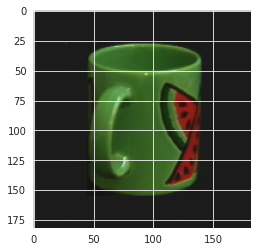

[0.0, 7.829076510059608, 18.183653155713067, 30.81570575172918, 45.0, 58.59094844784133, 71.31264849478883, 81.76902489880968, 89.683451952727, 97.52382043863864, 107.92791976200724, 120.66456458047988, 135.0, 148.73626830562256, 161.56505117707798, 172.0730733173104, 179.68345195272698, 187.92692668268958, 198.434948822922, 211.2637316943774, 224.99999999999997, 239.3354354195201, 252.07208023799274, 262.47617956136133, 269.99999999999994, 278.23097510119027, 288.6873515052111, 301.4090515521586, 314.99999999999994, 329.18429424827076, 341.8163468442869, 352.1709234899404]


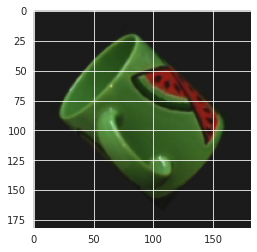

In [56]:
# load the target dataset
dataset = load_dataset(dataset_name, partial=None)

# find the target image
for d, data in enumerate(dataset):
    image = tf.cast(data['image'], tf.float32) / 255.
    if d == img_id:
        break

# radial beam sampling
lines, angles = instantiate_radial_beams(target_size + margin_padding, target_size + margin_padding,
                                         beam_set_size=n_beams,
                                         max_len=target_size // 2)

# zero pad the image by the min margin
padding_value = image[-1, -1, 0] if dataset_name == 'coil100' else 0.0

image = tf.pad(image, [
    [tf.math.maximum(0, (target_size + margin_padding - image.shape[1]) // 2),
     tf.math.maximum(0, (target_size + margin_padding - image.shape[1]) // 2)],
    [tf.math.maximum(0, (target_size + margin_padding - image.shape[0]) // 2),
     tf.math.maximum(0, (target_size + margin_padding - image.shape[0]) // 2)],
    [0, 0]], "CONSTANT", constant_values=padding_value)

plt.imshow(image)
plt.show()

print(angles)

# rotate image and evaluate beams
# angles = (np.array(angles)[::(n_beams // 4)] / 180) * math.pi
images = [tfa.image.rotate(image, angle, interpolation='bilinear', fill_value=padding_value) for angle in angles]
beams = np.array([tf.gather_nd(i, lines) for i in images])
n_beams, _, n_pixels, n_channels = beams[0].shape

plt.imshow(images[angle_id])
plt.show()

In [32]:
input_shape = [2, n_beams, 3, n_pixels, n_channels]
bic = BIC(hidden=128, activation=tf.nn.leaky_relu, context=True,
          l2_regularization=0.0, edge_factor=0.5, gcn_layers=3, dropout=0.0,
          n_beams=n_beams, pixel_count_per_beam=n_pixels)
_ = bic(tf.keras.layers.Input(input_shape))
bic = bic.functional_compile(input_shape)
bic.summary()
bic.load_weights(model_path)

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_12 (InputLayer)          [(None, 2, 32, 3, 6  0           []                               
                                4, 3)]                                                            
                                                                                                  
 beam_encoder (BeamEncoder)     (None, 2, 32, 128)   105920      ['input_12[0][0]']               
                                                                                                  
 tf.compat.v1.shape_10 (TFOpLam  (6,)                0           ['input_12[0][0]']               
 bda)                                                                                             
                                                                                            

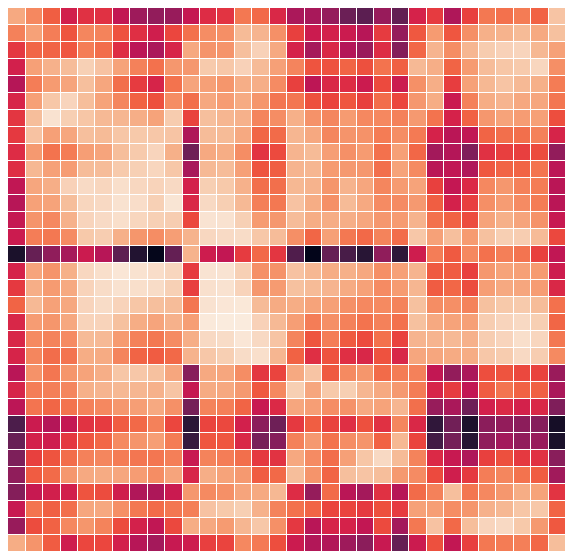

In [57]:
plt.figure(figsize=(10, 10))

_input = tf.cast([tf.concat([beams[0][None], beam[None]], axis=0) for beam in beams], tf.float32)
prior, unit_vec, beamencoding, ctx, similarity, \
beamencoding_zero, beamencoding_theta, angle_energy, rnn_encoding = bic(_input)

similarity = (similarity[angle_id] - tf.reduce_min(similarity[angle_id])) / \
             (tf.reduce_max(similarity[angle_id]) - tf.reduce_min(similarity[angle_id]))
sns.heatmap(similarity, linewidths=.5, cbar=False)
plt.xticks([])
plt.yticks([])
plt.savefig('img/similarity.pdf', dpi=150)
plt.show()